In [144]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
PassengerId=test['PassengerId']
total = pd.concat([train, test], ignore_index = True)

# 第一步 观察、分析数据

## 1.概览

In [145]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB


## 2.数据可视化

### （1）性别与存活率的关系

女性生存率:74.203822
男性生存率:18.890815


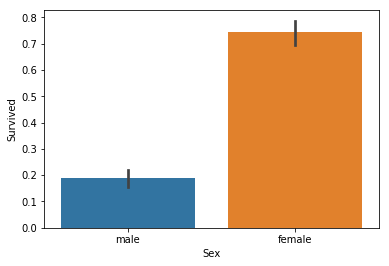

In [146]:
#此处使用了seaborn作为绘图工具，它实际上是对matplotlib的又一层封装，以简化使用
sns.barplot(x="Sex", y="Survived", data=train)
print("女性生存率:%f" % (train["Survived"][train["Sex"] == 'female'].value_counts(normalize = True)[1]*100))
print("男性生存率:%f" % (train["Survived"][train["Sex"] == 'male'].value_counts(normalize = True)[1]*100))

### （2）舱位等级与存活率的关系

一等舱存活率:62.962963
二等舱存活率:47.282609
三等舱存活率:24.236253


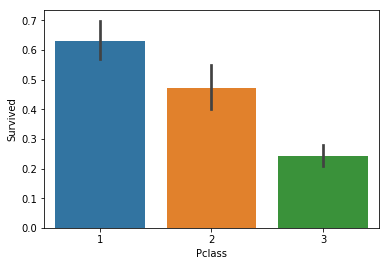

In [147]:
sns.barplot(x="Pclass", y="Survived", data=train)
print("一等舱存活率:%f" % (train["Survived"][train["Pclass"] == 1].value_counts(normalize = True)[1]*100))
print("二等舱存活率:%f" % (train["Survived"][train["Pclass"] == 2].value_counts(normalize = True)[1]*100))
print("三等舱存活率:%f" % (train["Survived"][train["Pclass"] == 3].value_counts(normalize = True)[1]*100))

### （3）家人数量与存活率的关系

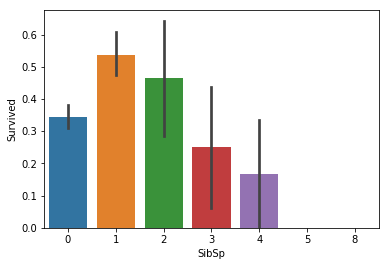

In [148]:
sns.barplot(x="SibSp", y="Survived", data=train)

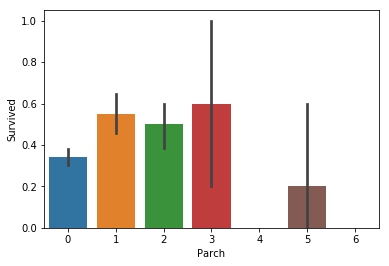

In [149]:
sns.barplot(x="Parch", y="Survived", data=train)

### （4）绘制生存率与年龄关系的密度图

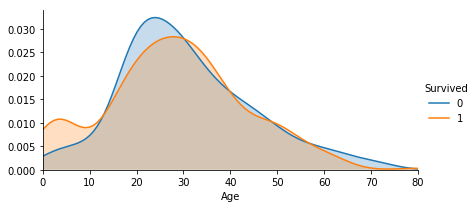

In [150]:
facet = sns.FacetGrid(train, hue="Survived",aspect=2)
facet.map(sns.kdeplot,'Age',shade= True)
facet.set(xlim=(0, train['Age'].max()))
facet.add_legend()

### （5）绘制生存率与票价关系的密度图

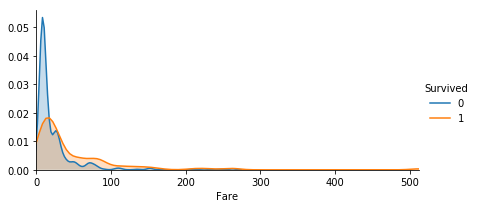

In [151]:
facet = sns.FacetGrid(train, hue="Survived",aspect=2)
facet.map(sns.kdeplot,'Fare',shade= True)
facet.set(xlim=(0,train['Fare'].max()))
facet.add_legend()

#### 去除部分极大值以增强可读性


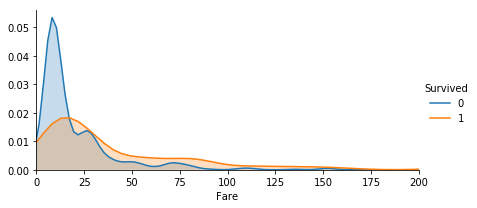

In [152]:
facet = sns.FacetGrid(train, hue="Survived",aspect=2)
facet.map(sns.kdeplot,'Fare',shade= True)
facet.set(xlim=(0, 200))
facet.add_legend()

# 第二步 特征工程

## 1.利用名称特征中的有用值：头衔，将其映射到身份，以探索身份与存活率的关系（详见实验报告）

In [153]:
total['Title'] = total['Name'].apply(lambda x:x.split(',')[1].split('.')[0].strip())
Title_Dict = {}
Title_Dict.update(dict.fromkeys(['Capt', 'Col', 'Major', 'Dr', 'Rev'], 'Officer'))
Title_Dict.update(dict.fromkeys(['Don', 'Sir', 'the Countess', 'Dona', 'Lady'], 'Royalty'))
Title_Dict.update(dict.fromkeys(['Mme', 'Ms', 'Mrs'], 'Mrs'))
Title_Dict.update(dict.fromkeys(['Mlle', 'Miss'], 'Miss'))
Title_Dict.update(dict.fromkeys(['Mr'], 'Mr'))
Title_Dict.update(dict.fromkeys(['Master','Jonkheer'], 'Master'))
total['Title'] = total['Title'].map(Title_Dict)

### 可视化结果

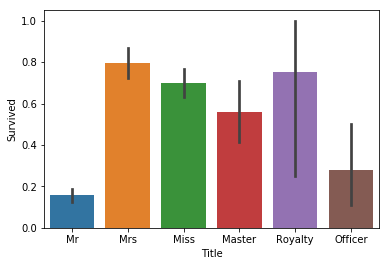

In [154]:
sns.barplot(x="Title", y="Survived", data=total)

## 2.合并特征：将兄弟姐妹与父母配偶合并为家庭人数，更深入地探索

In [155]:
total['FamilySize']=total['SibSp']+total['Parch']+1

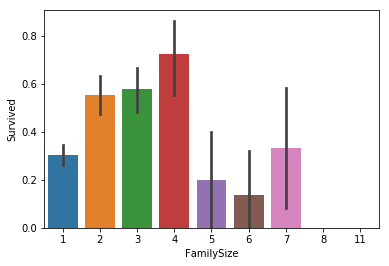

In [156]:
sns.barplot(x="FamilySize", y="Survived", data=total)

### 7种类型的特征不容易交给模型学习，将存活率过半的划分为一类，未过半的分为一类，过低的分为第三类。

In [157]:
def Family_Type(s):
    if (s >= 2) & (s <= 4):
        return 2
    elif ((s > 4) & (s <= 7)) | (s == 1):
        return 1
    elif (s > 7):
        return 0
total['Family_Type']=total['FamilySize'].apply(Family_Type)

#### 可视化结果

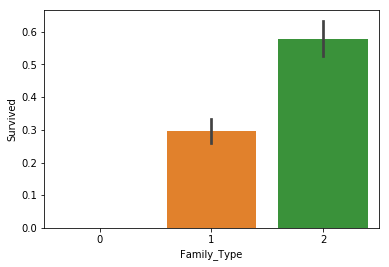

In [158]:
sns.barplot(x="Family_Type", y="Survived", data=total)

## 3.转化Cabin特征为首字母：

In [159]:
#以Unknown填补缺失值
total['Cabin'] = total['Cabin'].fillna('Unknown')
#更新Cabin中字符串为特征本身的缩写
total['Cabin']=total['Cabin'].str.get(0)

#### 可视化结果

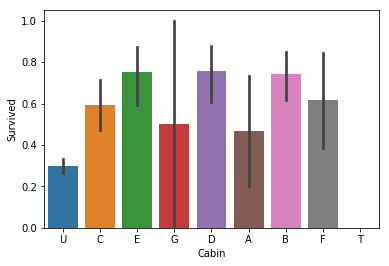

In [160]:
sns.barplot(x="Cabin", y="Survived", data=total)

## 4.处理船票编号，进行分组

In [161]:
Ticket_Count = dict(total['Ticket'].value_counts())
total['SameTicket'] = total['Ticket'].apply(lambda x:Ticket_Count[x])

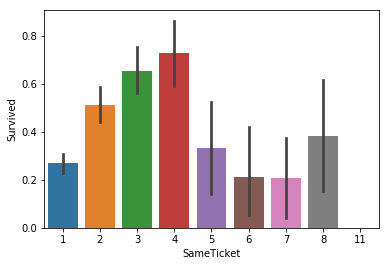

In [162]:
sns.barplot(x='SameTicket', y='Survived', data=total)

#### 按生存率把相同票号的人分为三类

In [163]:
def Ticket_Type(s):
    if (s >= 2) & (s <= 4):
        return 2
    elif ((s > 4) & (s <= 8)) | (s == 1):
        return 1
    elif (s > 8):
        return 0

total['SameTicket'] = total['SameTicket'].apply(Ticket_Type)

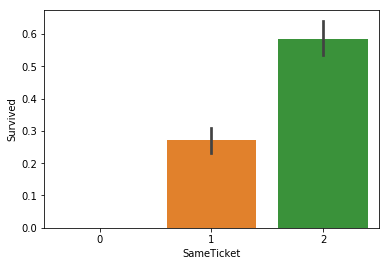

In [164]:
sns.barplot(x='SameTicket', y='Survived', data=total)

## 5.使用随机森林预测，填补年龄缺失值

In [165]:
from sklearn.ensemble import RandomForestRegressor

age_df = total[['Age', 'Pclass','Sex','Title']]
age_df=pd.get_dummies(age_df)
known_age = age_df[age_df.Age.notnull()].as_matrix()
unknown_age = age_df[age_df.Age.isnull()].as_matrix()
y = known_age[:, 0]
X = known_age[:, 1:]
rfr = RandomForestRegressor(random_state=0, n_estimators=100, n_jobs=-1)
rfr.fit(X, y)
predictedAges = rfr.predict(unknown_age[:, 1::])
total.loc[ (total.Age.isnull()), 'Age' ] = predictedAges 

In [166]:
total[total['Embarked'].isnull()]

,Age,Cabin,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket,Title,FamilySize,Family_Type,SameTicket
61,38.0,B,NaN,80.0,"Icard, Miss. Amelie",0,62,1,female,0,1.0,113572,Miss,1,1,2
829,62.0,B,NaN,80.0,"Stone, Mrs. George Nelson (Martha Evelyn)",0,830,1,female,0,1.0,113572,Mrs,1,1,2


In [167]:
total['Embarked'] = total['Embarked'].fillna('C')

In [168]:
total[total['Fare'].isnull()]


,Age,Cabin,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket,Title,FamilySize,Family_Type,SameTicket
1043,60.5,U,S,NaN,"Storey, Mr. Thomas",0,1044,3,male,0,NaN,3701,Mr,1,1,1


In [169]:
fare=total[(total['Embarked'] == "S") & (total['Pclass'] == 3)].Fare.median()
total['Fare']=total['Fare'].fillna(fare)

## 6.对测试集中离群数据进行惩罚性修改

### 把姓氏相同的乘客划分为同一组（定义为一个家庭），从人数大于一的组中分别提取出每组的妇女儿童和成年男性。

In [170]:
total['Surname']=total['Name'].apply(lambda x:x.split(',')[0].strip())
Surname_Count = dict(total['Surname'].value_counts())
total['FamilyGroup'] = total['Surname'].apply(lambda x:Surname_Count[x])
Female_Child_Group=total.loc[(total['FamilyGroup']>=2) & ((total['Age']<=12) | (total['Sex']=='female'))]
Male_Adult_Group=total.loc[(total['FamilyGroup']>=2) & (total['Age']>12) & (total['Sex']=='male')]

### 发现一个家庭中，绝大部分女性和儿童组的平均存活率基本都为1或0，即同组女性、儿童要么全部幸存，要么全部死亡。

In [171]:
Female_Child=pd.DataFrame(Female_Child_Group.groupby('Surname')['Survived'].mean().value_counts())
Female_Child

,Survived
1.000000,115
0.000000,31
0.750000,2
0.333333,1
0.142857,1


Text(0.5,0,'AverageSurvived')

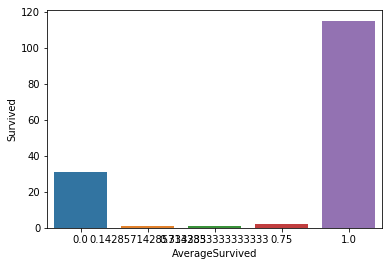

In [172]:
sns.barplot(x=Female_Child.index, y=Female_Child['Survived']).set_xlabel('AverageSurvived')


### 绝大部分成年男性组的平均存活率也基本为1或0。

In [173]:
Male_Adult=pd.DataFrame(Male_Adult_Group.groupby('Surname')['Survived'].mean().value_counts())
Male_Adult.columns
Male_Adult

,Survived
0.000000,122
1.000000,20
0.500000,6
0.333333,2
0.250000,1


Text(0.5,0,'AverageSurvived')

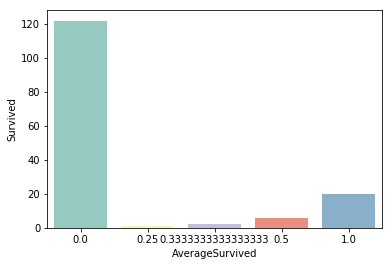

In [174]:
sns.barplot(x=Male_Adult.index, y=Male_Adult['Survived'], palette='Set3').set_xlabel('AverageSurvived')


### 从以上结果，可知通常女性和儿童幸存率高，成年男性幸存较低，所以开始关注不符合之前规律的反常组别。
### 把女性和儿童组中幸存率为0的组设置为遇难组，把成年男性组中存活率为1的设置为幸存组。猜想一家人基本生死与共，处于遇难组的女性和儿童幸存的可能性较低，处于幸存组的成年男性幸存的可能性较高。

In [175]:
Female_Child_Group=Female_Child_Group.groupby('Surname')['Survived'].mean()
Dead_List=set(Female_Child_Group[Female_Child_Group.apply(lambda x:x==0)].index)
print(Dead_List)
Male_Adult_List=Male_Adult_Group.groupby('Surname')['Survived'].mean()
Survived_List=set(Male_Adult_List[Male_Adult_List.apply(lambda x:x==1)].index)
print(Survived_List)

{'Attalah', 'Arnold-Franchi', 'Turpin', 'Jussila', 'Olsson', 'Oreskovic', 'Caram', 'Palsson', 'Zabour', 'Robins', 'Rice', 'Ilmakangas', 'Sage', 'Danbom', 'Rosblom', 'Van Impe', 'Vander Planke', 'Lahtinen', 'Lefebre', 'Cacic', 'Johnston', 'Goodwin', 'Panula', 'Skoog', 'Lobb', 'Bourke', 'Barbara', 'Ford', 'Canavan', 'Boulos', 'Strom'}
{'Bishop', 'Frolicher-Stehli', 'Greenfield', 'Jussila', 'Jonsson', 'Goldenberg', 'Kimball', 'Chambers', 'Nakid', 'Harder', 'Beckwith', 'Taylor', 'Dick', 'McCoy', 'Frauenthal', 'Bradley', 'Beane', 'Daly', 'Cardeza', 'Duff Gordon'}


### 为了使处于这两种反常组中的样本能够被正确分类，对测试集中处于反常组中的样本的Age，Title，Sex进行惩罚修改。

In [176]:
train=total.loc[total['Survived'].notnull()]
test=total.loc[total['Survived'].isnull()]
test.loc[(test['Surname'].apply(lambda x:x in Dead_List)),'Sex'] = 'male'
test.loc[(test['Surname'].apply(lambda x:x in Dead_List)),'Age'] = 60
test.loc[(test['Surname'].apply(lambda x:x in Dead_List)),'Title'] = 'Mr'
test.loc[(test['Surname'].apply(lambda x:x in Survived_List)),'Sex'] = 'female'
test.loc[(test['Surname'].apply(lambda x:x in Survived_List)),'Age'] = 5
test.loc[(test['Surname'].apply(lambda x:x in Survived_List)),'Title'] = 'Miss'

## 7.选择需要的特征

In [177]:
total=total.reindex(columns=['Survived','Pclass','Sex','Age','Fare','Embarked','Title','Family_Type','SameTicket'])
total=pd.get_dummies(total)
train=total[total['Survived'].notnull()]
test=total[total['Survived'].isnull()].drop('Survived',axis=1)
X = train.as_matrix()[:,1:]
y = train.as_matrix()[:,0]

In [178]:
total

,Survived,Pclass,Age,Fare,Family_Type,SameTicket,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S,Title_Master,Title_Miss,Title_Mr,Title_Mrs,Title_Officer,Title_Royalty
0,0.0,3,22.000000,7.2500,2,1,0,1,0,0,1,0,0,1,0,0,0
1,1.0,1,38.000000,71.2833,2,2,1,0,1,0,0,0,0,0,1,0,0
2,1.0,3,26.000000,7.9250,1,1,1,0,0,0,1,0,1,0,0,0,0
3,1.0,1,35.000000,53.1000,2,2,1,0,0,0,1,0,0,0,1,0,0
4,0.0,3,35.000000,8.0500,1,1,0,1,0,0,1,0,0,1,0,0,0
5,0.0,3,28.226256,8.4583,1,1,0,1,0,1,0,0,0,1,0,0,0
6,0.0,1,54.000000,51.8625,1,2,0,1,0,0,1,0,0,1,0,0,0
7,0.0,3,2.000000,21.0750,1,1,0,1,0,0,1,1,0,0,0,0,0
8,1.0,3,27.000000,11.1333,2,2,1,0,0,0,1,0,0,0,1,0,0
9,1.0,2,14.000000,30.0708,2,2,1,0,1,0,0,0,0,0,1,0,0


# 第三步 开始建模

## 1.网格搜索遍历，选取最优参数

In [179]:
from sklearn.pipeline import Pipeline,make_pipeline
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.feature_selection import SelectKBest
from sklearn import cross_validation, metrics
from sklearn.grid_search import GridSearchCV, RandomizedSearchCV


pipe=Pipeline([('select',SelectKBest(k=15)), 
               ('classify', RandomForestClassifier(max_features = 'sqrt'))])

param_test = {'classify__n_estimators':list(range(20,50,2)), 
              'classify__max_depth':list(range(3,60,3))}
gsearch = GridSearchCV(estimator = pipe, param_grid = param_test, scoring='roc_auc', cv=10)
gsearch.fit(X,y)
print(gsearch.best_params_, gsearch.best_score_)

{'classify__max_depth': 6, 'classify__n_estimators': 22} 0.881279711830316


## 2.训练随机森林模型

In [180]:
select = SelectKBest(k =15)
clf = RandomForestClassifier(random_state = 1, warm_start = True, 
                                  n_estimators = 26,
                                  max_depth = 6, 
                                  max_features = 'sqrt')
pipeline = make_pipeline(select, clf)
pipeline.fit(X, y)

Pipeline(memory=None,
     steps=[('selectkbest', SelectKBest(k=15, score_func=<function f_classif at 0x00000171F9E63D90>)), ('randomforestclassifier', RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=6, max_features='sqrt', max_leaf_nodes=None,
            min_impurity_decreas..._estimators=26, n_jobs=1,
            oob_score=False, random_state=1, verbose=0, warm_start=True))])

## 3.交叉验证

In [181]:
cv_score = cross_validation.cross_val_score(pipeline, X, y, cv= 10)
print("CV Score : Mean - %g | Std - %g " % (np.mean(cv_score), np.std(cv_score)))

CV Score : Mean - 0.8304954 | Std - 0.03576179 


## 4. 预测

In [182]:
predictions = pipeline.predict(test)
submission = pd.DataFrame({"PassengerId": PassengerId, "Survived": predictions.astype(np.int32)})
submission.to_csv("submission.csv", index=False)